# Let's draw samples from a nested Gaussian Process

We will draw samples from a $(m, n) = (2, 1)$ nested Gaussian process following [Zhu and Dunson (2013)](http://amstat.tandfonline.com/doi/abs/10.1080/01621459.2013.838568). 

For our first trick, we assume values for the random walk and observation noise variabilities and sample from the state space model

$$\begin{align}
Y_j &\sim Z_j \theta_j + \epsilon_j \\
\theta_{j+1} &= G_j \theta_j + \omega_j \\
\theta &= \begin{bmatrix} U \\ DU \\ A \end{bmatrix} \\
\epsilon_j &\sim \mathcal{N}(0, \sigma^2_\epsilon) \\
\omega_j &\sim \mathcal{N}(0, W_j) \\
Z_j &= 
    \begin{pmatrix} 
    1 & 0 & 0
    \end{pmatrix} \\
G_j &= 
    \begin{pmatrix} 
    1 & \delta_j & \frac{\delta_j^2}{2} \\
    0 & 1 & \delta_j \\
    0 & 0 & 1
    \end{pmatrix} \\
W_j & = 
    \begin{pmatrix}
    \frac{\delta_j^3}{3} \sigma_U^2 + \frac{\delta_j^5}{20} \sigma_A^2 &
    \frac{\delta_j^2}{2} \sigma_U^2 + \frac{\delta_j^4}{8} \sigma_A^2 &
    \frac{\delta_j^3}{6} \sigma_A^2 \\
    \frac{\delta_j^2}{2} \sigma_U^2 + \frac{\delta_j^4}{8} \sigma_A^2 &
    \delta_j \sigma_U^2 + \frac{\delta_j^3}{3} \sigma_A^2 &
    \frac{\delta_j^2}{2} \sigma_A^2 \\
    \frac{\delta_j^3}{6} \sigma_A^2 &
    \frac{\delta_j^2}{2} \sigma_A^2 &
    \delta_j \sigma_A^2
    \end{pmatrix} \\
\theta_0 &\sim \mathcal{N}(0, \mathrm{diag}(\sigma^2_\mu, \sigma^2_\mu, \sigma^2_\alpha))
\end{align}$$

In the above, we take $\delta_j \equiv t_{j + 1} - t_j$ and assume $\sigma^2_\mu$ and $\sigma^2_\alpha$ are specified as part of the prior.

# Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sstools as ss
import ngptools as ngp
%matplotlib inline
sns.set_style('darkgrid')

np.random.seed(12349)  # set random seed

## Set up system matrices and dimensions

In [2]:
Nt = 100
tobs = np.linspace(0, 1, Nt)

Now we can create the multidimensional arrays needed to sample our state space model:

In [3]:
Np = 1
Nm = 3
Nr = 3

sigeps = 1
sigA = 50
sigU = .25
sigmu = 3
sigalpha = 1.

# we need as many deltas as observations
# the last delta corresponds to a hypothetical point at which we want to make a 
# prediction about the state
tpred = 1.1
delta = np.diff(np.concatenate([tobs, [tpred]]))

## Create fake data

In [4]:
y, alpha = ngp.generate((Np, Nm, Nr), delta, sigeps, sigU, sigA, sigmu, sigalpha)

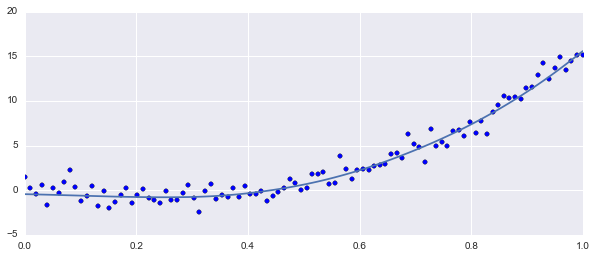

In [5]:
plt.figure(figsize=(10, 4))
plt.scatter(tobs, y, label='data');
plt.plot(tobs, alpha[:, 0])
plt.xlim(tobs[0], tobs[-1])
pass

In [6]:
Ns = 500  # number of samples

alpha_samples = ngp.sample(y, Ns, (Np, Nm, Nr), delta, sigeps, sigU, sigA, sigmu, sigalpha)

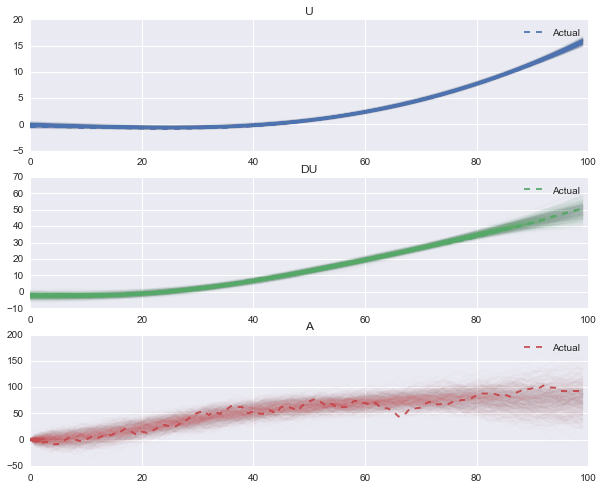

In [7]:
trans = 5 / Ns
plt.figure(figsize=(10, 8))
th_names = [r'U', r'DU', r'A']

for idx in range(Nm):
    plt.subplot(Nm, 1, idx + 1)
    plt.plot(alpha[..., idx], color=sns.color_palette()[idx], linestyle='--', label='Actual')
    plt.plot(alpha_samples[..., idx].T, color=sns.color_palette()[idx], alpha=trans)
    plt.title(th_names[idx])
    plt.legend()
pass